# Predicting the Sales Price of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

We're going to take the following approach:
1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

## 1. Problem Definition

In a statement,
> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers.

## 2. Data

The data is downloaded from Kaggle Bluebooks for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.
  
The key fields are in train.csv are:

* **SalesID**: the uniue identifier of the sale
* **MachineID**: the unique identifier of a machine.  A machine can be sold multiple times
* **saleprice**: what the machine sold for at auction (only provided in train.csv)
* **saledate**: the date of the sale

## 3. Evaluation

> The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check:
https://www.kaggle.com/c/bluebook-for-bulldozers/overview

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimizes RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset.  You can view this data dictionary on Google Sheets:
https://docs.google.com/spreadsheets/d/1ZXUqGLvvc_dZqyfUkgx_T8GXZLUDyxvadW4S0uTnigI/edit?usp=sharing

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [100]:
# Import training and validation sets
df = pd.read_csv("./data/bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory=False)

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [103]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

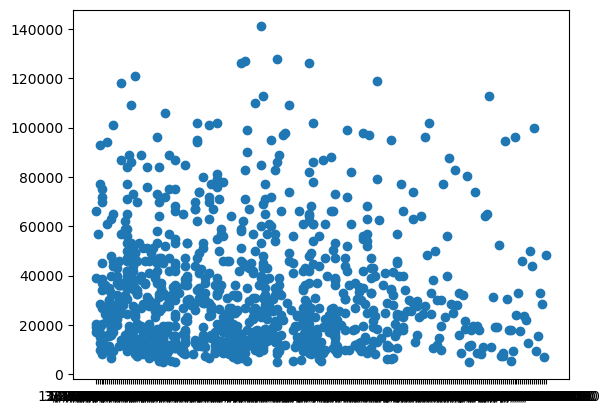

In [104]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);
plt.show()

In [105]:
df.saledate[:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

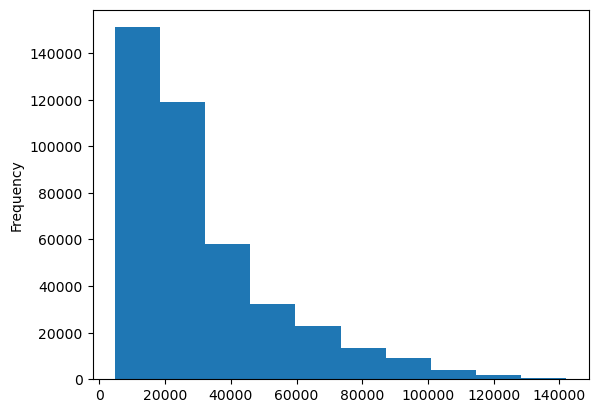

In [106]:
df.SalePrice.plot.hist();
plt.show()

### Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter.

In [128]:
# Import data again but this time parse dates
df = pd.read_csv("./data/bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"])

In [129]:
df.saledate.dtype

dtype('<M8[ns]')

In [130]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

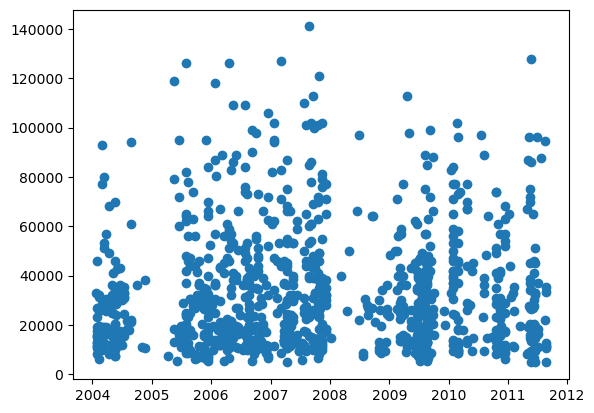

In [131]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])
plt.show()

In [132]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [112]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate

When working with time series data, it's a good idea to sort by date.

In [144]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
233186   1989-01-31
142491   1989-01-31
115536   1989-01-31
92301    1989-01-31
115892   1989-01-31
134080   1989-01-31
92294    1989-01-31
31494    1989-01-31
140922   1989-01-31
66337    1989-01-31
92531    1989-01-31
82122    1989-01-31
92256    1989-01-31
145670   1989-01-31
92780    1989-01-31
238373   1989-01-31
127132   1989-01-31
115102   1989-01-31
32317    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

We make a copy of the original dataframe wo when we manipulate the copy, we've still got our original data.

In [145]:
# Make a copy 
df_tmp = df.copy()

In [143]:
# Clear the df_copy DataFrame
df_copy = pd.DataFrame()

### Add datetime parameters for `saledate' column

In [146]:
df_tmp.head(20)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
233186,1728883,30000.0,1523610,9105,132,99.0,1986,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142491,1508502,21000.0,1153157,4138,132,99.0,1972,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Angle,None or Unspecified,NaN,NaN
115536,1452578,33000.0,1544443,3854,132,99.0,1974,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
92301,1403418,24000.0,1390168,7110,132,99.0,1986,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115892,1453054,36000.0,1117184,3854,132,99.0,1977,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
134080,1491298,46000.0,1322436,4107,132,99.0,1987,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
92294,1403411,23000.0,1184544,7110,132,99.0,1986,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31494,1263797,17000.0,1526902,6953,132,99.0,1983,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
140922,1504404,26000.0,1310407,4139,132,99.0,1975,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Angle,None or Unspecified,NaN,NaN


In [147]:
def preprocess_data_using_lambda(df_tmp):
    """
    Preprocess the input DataFrame by handling datetime features, 
    missing numeric values, and encoding categorical variables.

    Parameters:
    df (pd.DataFrame): The input DataFrame to be preprocessed.

    Returns:
    pd.DataFrame: The preprocessed DataFrame with additional features and missing value handling.
    """
    # Lambda for adding datetime parameters for 'saledate'
    add_datetime_features = lambda x: (x.dt.year, x.dt.month, x.dt.day, x.dt.dayofweek, x.dt.dayofyear)
    df_tmp["saleYear"], df_tmp["saleMonth"], df_tmp["saleDay"], df_tmp["saleDayofweek"], df_tmp["saleDayofyear"] = add_datetime_features(df_tmp.saledate)
    
    # Drop original 'saledate'
    df_tmp.drop("saledate", axis=1, inplace=True)

    # This will turn all of the object (string) values into category values
    df_tmp[df_tmp.select_dtypes(include='object').columns] = df_tmp.select_dtypes(include='object').apply(lambda x: x.astype('category'))
    
    # Lambda to fill missing numeric data with the median
    fill_numeric = lambda col: col.fillna(col.median()) if pd.isnull(col).sum() else col

    # Apply preprocessing steps
    for label, content in df_tmp.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df_tmp[label + "_is_missing"] = content.isnull()
                df_tmp[label] = fill_numeric(content)
        else:
            df_tmp[label + "_is_missing"] = content.isnull()
            df_tmp[label] = pd.Categorical(content).codes + 1

    # Match test dataset columns to training dataset
    # df_test["auctioneerID_is_missing"] = False
    # df_test.head()
    
    return df_tmp

In [148]:
df_tmp = preprocess_data_using_lambda(df_tmp)

In [172]:
# Add datetime parameters for saledate
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [149]:
df_tmp.head().T

,205615,233186,142491,115536,92301
SalesID,1646770,1728883,1508502,1452578,1403418
SalePrice,9500.0,30000.0,21000.0,33000.0,24000.0
MachineID,1126363,1523610,1153157,1544443,1390168
ModelID,8434,9105,4138,3854,7110
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,True
Blade_Type_is_missing,False,True,False,True,True
Travel_Controls_is_missing,False,True,False,True,True
Differential_Type_is_missing,True,True,True,False,True


In [174]:
# Now we've enriched our DataFrame with date time features, we can remove `saledate`.
df_tmp.drop("saledate", axis=1, inplace=True)

In [115]:
# Check the values of different columns
df_tmp.state.value_counts().head()

state
Florida       67320
Texas         53110
California    29761
Washington    16222
Georgia       14633
Name: count, dtype: int64

In [81]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


In [150]:
len(df_tmp)

412698

In [151]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
233186,1728883,30000.0,1523610,9105,132,99.0,1986,0.0,0,4772,...,True,True,True,True,True,True,True,True,True,True
142491,1508502,21000.0,1153157,4138,132,99.0,1972,0.0,0,2347,...,True,True,True,True,True,False,False,False,True,True
115536,1452578,33000.0,1544443,3854,132,99.0,1974,0.0,0,1767,...,True,True,True,True,True,True,True,True,False,False
92301,1403418,24000.0,1390168,7110,132,99.0,1986,0.0,0,744,...,True,True,True,True,True,True,True,True,True,True


In [152]:
df_tmp.isna().sum()[:50]

SalesID                     0
SalePrice                   0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
UsageBand                   0
fiModelDesc                 0
fiBaseModel                 0
fiSecondaryDesc             0
fiModelSeries               0
fiModelDescriptor           0
ProductSize                 0
fiProductClassDesc          0
state                       0
ProductGroup                0
ProductGroupDesc            0
Drive_System                0
Enclosure                   0
Forks                       0
Pad_Type                    0
Ride_Control                0
Stick                       0
Transmission                0
Turbocharged                0
Blade_Extension             0
Blade_Width                 0
Enclosure_Type              0
Engine_Horsepower           0
Hydraulics                  0
Pushblock                   0
Ripper    

In [153]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int32(5), int64(5), int8(40)
memory usage: 73.2 MB


In [154]:
df_tmp.info();

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int32(5), int64(5), int8(40)
memory usage: 73.2 MB


In [155]:
df_tmp["UsageBand"].dtype

dtype('int8')

In [156]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

### Convert strings to categories

One way we can turn all of our data into numbers is by converting them into pandas categories.

We can check the different datatypes compatible with pandas here:
https://pandas.pydata.org/docs/user_guide/categorical.html

In [157]:
# Find the columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

In [81]:
# If you're wondering what df.items() does, here's an example
random_dict = {"key1": "hello",
               "key2": "world!"}

for key, value in random_dict.items():
    print(f"{key} {value}")

key1 hello
key2 world!


In [182]:
# This will turn all of the string values into category values
df_tmp[df_tmp.select_dtypes(include='object').columns] = df_tmp.select_dtypes(include='object').apply(lambda x: x.astype('category'))

In [158]:
df_tmp.state.cat.categories

AttributeError: Can only use .cat accessor with a 'category' dtype

In [159]:
df_tmp.state.cat.codes

AttributeError: Can only use .cat accessor with a 'category' dtype

Thanks to pandas Categories we now have a way to access all our data in form of numbers.

But we still have a bunch of missing data...

In [160]:
# Check missing data
df_tmp.isnull().sum()/len(df_tmp)

SalesID                         0.0
SalePrice                       0.0
MachineID                       0.0
ModelID                         0.0
datasource                      0.0
                               ... 
Backhoe_Mounting_is_missing     0.0
Blade_Type_is_missing           0.0
Travel_Controls_is_missing      0.0
Differential_Type_is_missing    0.0
Steering_Controls_is_missing    0.0
Length: 103, dtype: float64

### Save preprocessed data


In [93]:
# Export current tmp dataframe
df_tmp.to_csv("./data/bluebook-for-bulldozers/train_tmp.csv",
              index=False)

In [138]:
# Import preprocessed data
df_tmp = pd.read_csv("./data/bluebook-for-bulldozers/train_tmp.csv",
                     low_memory=False)
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [127]:
def preprocess_data_using_lambda(df_tmp):
    """
    Preprocess the input DataFrame by handling datetime features, 
    missing numeric values, and encoding categorical variables.

    Parameters:
    df (pd.DataFrame): The input DataFrame to be preprocessed.

    Returns:
    pd.DataFrame: The preprocessed DataFrame with additional features and missing value handling.
    """
    # Lambda for adding datetime parameters for 'saledate'
    add_datetime_features = lambda x: (x.dt.year, x.dt.month, x.dt.day, x.dt.dayofweek, x.dt.dayofyear)
    df_tmp["saleYear"], df_tmp["saleMonth"], df_tmp["saleDay"], df_tmp["saleDayofweek"], df_tmp["saleDayofyear"] = add_datetime_features(df_tmp.saledate)
    
    # Drop original 'saledate'
    df_tmp.drop("saledate", axis=1, inplace=True)

    # This will turn all of the object (string) values into category values
    df_tmp[df_tmp.select_dtypes(include='object').columns] = df_tmp.select_dtypes(include='object').apply(lambda x: x.astype('category'))
    
    # Lambda to fill missing numeric data with the median
    fill_numeric = lambda col: col.fillna(col.median()) if pd.isnull(col).sum() else col

    # Apply preprocessing steps
    for label, content in df_tmp.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df_tmp[label + "_is_missing"] = content.isnull()
                df_tmp[label] = fill_numeric(content)
        else:
            df_tmp[label + "_is_missing"] = content.isnull()
            df_tmp[label] = pd.Categorical(content).codes + 1

    # Match test dataset columns to training dataset
    # df_test["auctioneerID_is_missing"] = False
    # df_test.head()
    
    return df_tmp

In [118]:
preprocess_data_using_lambda(df_tmp)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
274835,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
141296,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
212552,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
62755,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,0.0,0,2101,...,True,True,True,True,True,False,False,False,True,True
412476,6324811,6000.0,1919104,19330,149,99.0,2004,0.0,0,240,...,True,True,True,True,True,True,True,True,True,True
411927,6313029,16000.0,1918416,17244,149,99.0,2004,0.0,0,627,...,True,True,True,True,True,True,True,True,True,True
407124,6266251,55000.0,509560,3357,149,99.0,1993,0.0,0,83,...,True,True,True,True,True,True,True,True,True,True


In [161]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
233186,1728883,30000.0,1523610,9105,132,99.0,1986,0.0,0,4772,...,True,True,True,True,True,True,True,True,True,True
142491,1508502,21000.0,1153157,4138,132,99.0,1972,0.0,0,2347,...,True,True,True,True,True,False,False,False,True,True
115536,1452578,33000.0,1544443,3854,132,99.0,1974,0.0,0,1767,...,True,True,True,True,True,True,True,True,False,False
92301,1403418,24000.0,1390168,7110,132,99.0,1986,0.0,0,744,...,True,True,True,True,True,True,True,True,True,True


In [162]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

In [163]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int32(5), int64(5), int8(40)
memory usage: 73.2 MB


## Fill missing values

### Fill numerical missing values first

In [164]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls
saleYear
saleMonth
saleDay
saleDayofweek
saleDayofyear
auctioneerID_is_missing
MachineHoursCurrentMeter_is_missing
UsageBand_is_missing
fiModelDesc_is_missing
fiBaseModel_is_missing
fiSecondaryDesc_is_missing
fiModelSeries_is_missing
fiModelDescriptor_is_missing
ProductSize_is_missing
fiProductClassDesc_is_missing
state_is_missing
Pro

In [120]:
# Apply a lambda function to numeric columns without changing them
# Get the column names for numeric datatypes only
numeric_columns = df.select_dtypes(include=['number']).columns

# Display the column names
print(numeric_columns)

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter'],
      dtype='object')


In [165]:
df_tmp.ModelID

205615     8434
233186     9105
142491     4138
115536     3854
92301      7110
          ...  
409901     4605
405777     6868
411889    17231
411890    17231
409203     4701
Name: ModelID, Length: 412698, dtype: int64

In [166]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [131]:
# Fill numeric rows with the median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells if the data is missing or not
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median which is more robust
            df_tmp[label] = content.fillna(content.median())

In [128]:
hundreds = np.full((1000,), 100)
hundreds_billion = np.append(hundreds, 100000000)
np.mean(hundreds), np.mean(hundreds_billion), np.median(hundreds), np.mean(hundreds_billion)

(100.0, 100000.0, 100.0, 100000.0)

In [132]:
# Check if there's any null numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [167]:
# Check to see how many examples were missing 
df_tmp.auctioneerID_is_missing.value_counts()

auctioneerID_is_missing
False    392562
True      20136
Name: count, dtype: int64

In [168]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

### Filling and turning categorical variables into numbers

In [169]:
# Check for columns which aren't numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

In [140]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells if the data is missing or not
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Turn categories into numbers and add +1
            df_tmp[label] = pd.Categorical(content).codes + 1

In [170]:
pd.Categorical(df_tmp["state"]).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [171]:
pd.Categorical(df_tmp["UsageBand"]).codes

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [172]:
df_tmp.head().T

,205615,233186,142491,115536,92301
SalesID,1646770,1728883,1508502,1452578,1403418
SalePrice,9500.0,30000.0,21000.0,33000.0,24000.0
MachineID,1126363,1523610,1153157,1544443,1390168
ModelID,8434,9105,4138,3854,7110
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,True
Blade_Type_is_missing,False,True,False,True,True
Travel_Controls_is_missing,False,True,False,True,True
Differential_Type_is_missing,True,True,True,False,True


In [173]:
df_tmp.isna().sum()[:15]

SalesID                     0
SalePrice                   0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
UsageBand                   0
fiModelDesc                 0
fiBaseModel                 0
fiSecondaryDesc             0
fiModelSeries               0
fiModelDescriptor           0
ProductSize                 0
dtype: int64

In [174]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int32(5), int64(5), int8(40)
memory usage: 73.2 MB


In [175]:
df_tmp.state.dtype

dtype('int8')

In [184]:
len(df_tmp)

412698

In [176]:
df_tmp.saleYear.value_counts()

saleYear
2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: count, dtype: int64

## 5. Modelling
We've done enough EDA (we could always do more) but let's start to do some model-driven EDA.

Now that all of data is numeric as well as our dataframe has no missing values, we should be able to build a machine learning model.

In [189]:
%%time
# Let's build a machine learning model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=300000)

# Fit the model
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

CPU times: total: 20min 12s
Wall time: 2min 49s


RandomForestRegressor(max_samples=300000, n_jobs=-1, random_state=42)

In [193]:
# Score the model
model.score(df_tmp.drop("SalePrice", axis=1), df_tmp.SalePrice)

0.9786063691634654

**Question**: Why doesn't the above metric hold water? (why isn't the metric reliable)

## Splitting data into train/validation sets

In [190]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
233186,1728883,30000.0,1523610,9105,132,99.0,1986,0.0,0,4772,...,True,True,True,True,True,True,True,True,True,True
142491,1508502,21000.0,1153157,4138,132,99.0,1972,0.0,0,2347,...,True,True,True,True,True,False,False,False,True,True
115536,1452578,33000.0,1544443,3854,132,99.0,1974,0.0,0,1767,...,True,True,True,True,True,True,True,True,False,False
92301,1403418,24000.0,1390168,7110,132,99.0,1986,0.0,0,744,...,True,True,True,True,True,True,True,True,True,True


In [192]:
df_tmp.saleYear.value_counts()

saleYear
2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: count, dtype: int64

In [194]:
# Split data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [195]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [196]:
y_train

205615     9500.0
233186    30000.0
142491    21000.0
115536    33000.0
92301     24000.0
           ...   
397551    34500.0
397589    19000.0
397660    24000.0
397995    18000.0
397022    24000.0
Name: SalePrice, Length: 401125, dtype: float64

In [197]:
X_train

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
233186,1728883,1523610,9105,132,99.0,1986,0.0,0,4772,1852,...,True,True,True,True,True,True,True,True,True,True
142491,1508502,1153157,4138,132,99.0,1972,0.0,0,2347,713,...,True,True,True,True,True,False,False,False,True,True
115536,1452578,1544443,3854,132,99.0,1974,0.0,0,1767,535,...,True,True,True,True,True,True,True,True,False,False
92301,1403418,1390168,7110,132,99.0,1986,0.0,0,744,245,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397551,6286845,1818840,8050,149,2.0,2006,0.0,0,493,176,...,True,True,True,True,True,True,True,True,True,True
397589,6287076,1862704,4640,149,2.0,1000,0.0,0,732,242,...,True,True,True,True,True,True,True,True,True,True
397660,6287313,1805275,4666,149,2.0,2004,0.0,0,865,267,...,True,True,True,True,True,False,False,False,True,True
397995,6288403,1908296,26287,149,2.0,1000,0.0,0,1818,557,...,True,True,True,True,True,True,True,True,True,True


In [183]:
%%time
# Cutting down the max number of samples each tree can see improves training time
model.fit(X_train, y_train)

CPU times: total: 8min 10s
Wall time: 1min 11s


RandomForestRegressor(max_samples=100000, n_jobs=-1)

## Build an evaluation function

In [205]:
# Create evaluation function (the competition uses Root Mean Square Log Error)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

def rmsle(y_test, y_preds):
    """
    Calculate root mean squared log error between predictions and 
    true labels
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": model.score(X_train, y_train),
              "Valid R^2": model.score(X_valid, y_valid)}
    return scores

### Testing our model on a subset (tune the hyperparameters)

In [200]:
# Tune our machine learning model faster tuning the hyperparameters!
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000)

In [201]:
%%time
# Cutting down on the max number of samples each estimator can see improves training time.
model.fit(X_train, y_train)

CPU times: total: 54.2 s
Wall time: 7.76 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [199]:
X_train.shape[0] * 100 /1

40112500.0

In [206]:
show_scores(model)

{'Training MAE': 5548.995840324089,
 'Valid MAE': 7179.6961392897265,
 'Training RMSLE': 0.25737726780537257,
 'Valid RMSLE': 0.29404344200903443,
 'Training R^2': 0.8610738743845616,
 'Valid R^2': 0.8320179198265638}

## Hyperparameter tuning with RandomizedSearchCV

In [213]:
%%time 
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1.0, "sqrt"], # Note: "max_features='auto'" is equivalent to "max_features=1.0", as of Scikit-Learn version 1.1
           "max_samples": [10000]}

# Instantiate RandomSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=10,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 9min 33s
Wall time: 1min 41s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1.0, 'sqrt'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [214]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 18,
 'min_samples_leaf': 15,
 'max_samples': 10000,
 'max_features': 1.0,
 'max_depth': None}

In [215]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 6353.232871501173,
 'Valid MAE': 7940.094027208802,
 'Training RMSLE': 0.2864757443036701,
 'Valid RMSLE': 0.316196506933704,
 'Training R^2': 0.8173107385441527,
 'Valid R^2': 0.7847494252613915}

## Train a model with the best hyperparameters

**Note**: These were found after 100 iterations of `RandomizedSearchCV`.

In [216]:
%%time
# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42) # random state so our results are reproducible

# Fit the ideal model
ideal_model.fit(X_train, y_train)

CPU times: total: 4min 43s
Wall time: 40.9 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1)

In [217]:
# Scores for ideal_model (trained on all the data)
show_scores(ideal_model)

{'Training MAE': 2951.654390837776,
 'Valid MAE': 5961.383818401332,
 'Training RMSLE': 0.14452094169692892,
 'Valid RMSLE': 0.24620656575510863,
 'Training R^2': 0.9589803969742698,
 'Valid R^2': 0.8808887908474958}

In [218]:
# Scores on rs_model (only trained on ~10,000 examples)
show_scores(rs_model)

{'Training MAE': 6353.232871501173,
 'Valid MAE': 7940.094027208804,
 'Training RMSLE': 0.2864757443036701,
 'Valid RMSLE': 0.31619650693370394,
 'Training R^2': 0.8173107385441527,
 'Valid R^2': 0.7847494252613915}

## Make predictions on Test data

In [248]:
# Import test data
df_test = pd.read_csv("./data/bluebook-for-bulldozers/Test.csv")
df_test['saledate'] = pd.to_datetime(df_test['saledate'])  # Ensure 'saledate' is in datetime format
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [249]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
67974    1989-01-31
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [221]:
# Make predictions on the test dataset
test_preds = ideal_model.predict(df_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
- Blade_Type_is_missing
- Blade_Width_is_missing
- Coupler_System_is_missing
- ...


In [250]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

In [251]:
df_test.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'saledate',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [252]:
X_train.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel',
       ...
       'Undercarriage_Pad_Width_is_missing', 'Stick_Length_is_missing',
       'Thumb_is_missing', 'Pattern_Changer_is_missing',
       'Grouser_Type_is_missing', 'Backhoe_Mounting_is_missing',
       'Blade_Type_is_missing', 'Travel_Controls_is_missing',
       'Differential_Type_is_missing', 'Steering_Controls_is_missing'],
      dtype='object', length=102)

## Preprocessing the data (getting the test dataset in the same format as our training dataset)

In [226]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    # Add datetime parameters for saledate
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayofweek"] = df.saledate.dt.dayofweek
    df["saleDayofyear"] = df.saledate.dt.dayofyear

    # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill numeric rows with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
                
        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1 
    # Match test dataset columns to training dataset
    df_test["auctioneerID_is_missing"] = False
    df_test.head()
    
    return df

In [253]:
# Process the test data
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [241]:
import pandas as pd

def preprocess_data_using_lambda(df):
    """
    Preprocess the input DataFrame by handling datetime features, 
    missing numeric values, and encoding categorical variables.

    Parameters:
    df (pd.DataFrame): The input DataFrame to be preprocessed.

    Returns:
    pd.DataFrame: The preprocessed DataFrame with additional features and missing value handling.
    """
    # Lambda for adding datetime parameters for 'saledate'
    add_datetime_features = lambda x: (x.dt.year, x.dt.month, x.dt.day, x.dt.dayofweek, x.dt.dayofyear)

    # Ensure 'saledate' is in datetime format before extracting features
    if pd.api.types.is_datetime64_any_dtype(df['saledate']):
        df["saleYear"], df["saleMonth"], df["saleDay"], df["saleDayofweek"], df["saleDayofyear"] = add_datetime_features(df.saledate)
    else:
        raise ValueError("The 'saledate' column must be in datetime format.")

    # Drop original 'saledate'
    df.drop("saledate", axis=1, inplace=True)

    # Convert all object (string) columns to category
    df[df.select_dtypes(include='object').columns] = df.select_dtypes(include='object').apply(lambda x: x.astype('category'))

    # Lambda to fill missing numeric data with the median
    fill_numeric = lambda col: col.fillna(col.median()) if pd.isnull(col).sum() > 0 else col

    # Apply preprocessing steps
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum() > 0:
                df[label + "_is_missing"] = content.isnull()
                df[label] = fill_numeric(content)
        else:
            df[label + "_is_missing"] = content.isnull()
            df[label] = pd.Categorical(content).codes + 1

    # Optionally handle test dataset (if required)
    # df_test["auctioneerID_is_missing"] = False

    return df

In [242]:
# Process the test data
df_test = preprocess_data_using_lambda(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [243]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
233186,1728883,1523610,9105,132,99.0,1986,0.0,0,4772,1852,...,True,True,True,True,True,True,True,True,True,True
142491,1508502,1153157,4138,132,99.0,1972,0.0,0,2347,713,...,True,True,True,True,True,False,False,False,True,True
115536,1452578,1544443,3854,132,99.0,1974,0.0,0,1767,535,...,True,True,True,True,True,True,True,True,False,False
92301,1403418,1390168,7110,132,99.0,1986,0.0,0,744,245,...,True,True,True,True,True,True,True,True,True,True


In [254]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

set()

In [255]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test["auctioneerID_is_missing"] = False

In [256]:
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


Finally now our test dataframe has the same features as our training dataframe, we can make predictions!

In [258]:
# Ensure the test dataset has the same columns as the training dataset
# First, identify any columns that might be missing or extra
missing_cols = set(X_train.columns) - set(df_test.columns)
extra_cols = set(df_test.columns) - set(X_train.columns)

# Add missing columns with default values (e.g., 0 or the median)
for col in missing_cols:
    df_test[col] = 0  # or df_test[col] = df_tmp[col].median()

# Remove any extra columns
df_test = df_test[X_train.columns]

# Now, the test dataset has the same columns and order as the training dataset
test_preds = ideal_model.predict(df_test)

In [259]:
test_preds

array([16225.59753231, 15671.39624126, 51600.66302612, ...,
       13856.20857767, 17414.62504598, 29068.62367423])

We've made some predictions but they're not in the same format Kaggle is asking for:
https://www.kaggle.com/c/bluebook-for-bulldozers/overview

In [263]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,16225.597532
1,1227844,15671.396241
2,1227847,51600.663026
3,1227848,65184.550427
4,1227863,53287.955921
...,...,...
12452,6643171,36400.518459
12453,6643173,12453.261264
12454,6643184,13856.208578
12455,6643186,17414.625046


In [265]:
# Export prediction data
df_preds.to_csv("./data/bluebook-for-bulldozers/test_predictions.csv", index=False)

### Feature Importance

Feature importance seeks to figure out which different attributes of the data were most importance when it comes to predicting the **target variable** (SalePrice)

In [266]:
len(ideal_model.feature_importances_)

102

In [267]:
X_train

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
233186,1728883,1523610,9105,132,99.0,1986,0.0,0,4772,1852,...,True,True,True,True,True,True,True,True,True,True
142491,1508502,1153157,4138,132,99.0,1972,0.0,0,2347,713,...,True,True,True,True,True,False,False,False,True,True
115536,1452578,1544443,3854,132,99.0,1974,0.0,0,1767,535,...,True,True,True,True,True,True,True,True,False,False
92301,1403418,1390168,7110,132,99.0,1986,0.0,0,744,245,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397551,6286845,1818840,8050,149,2.0,2006,0.0,0,493,176,...,True,True,True,True,True,True,True,True,True,True
397589,6287076,1862704,4640,149,2.0,1000,0.0,0,732,242,...,True,True,True,True,True,True,True,True,True,True
397660,6287313,1805275,4666,149,2.0,2004,0.0,0,865,267,...,True,True,True,True,True,False,False,False,True,True
397995,6288403,1908296,26287,149,2.0,1000,0.0,0,1818,557,...,True,True,True,True,True,True,True,True,True,True


In [277]:
# Install Seaborn package in current environment (if you don't have it)
import sys
!conda install --yes --prefix {sys.prefix} seaborn

Retrieving notices: ...working... done
Channels:
 - defaults
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ZeroToMastery\AI_ML_Engineer\ml-course\bulldozer-price-prediction-project\env

  added / updated specs:
    - seaborn


The following NEW packages will be INSTALLED:

  seaborn            pkgs/main/win-64::seaborn-0.13.2-py312haa95532_0 



Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [308]:
import seaborn as sns

# Define a custom palette with a salmon color
custom_palette = sns.color_palette(["#FF6F61", "#3498db", "#2ecc71"])  # Salmon-like color + others

In [309]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    """
    Plots the top n most important features based on their importances.
    
    Parameters:
    columns (list): A list of feature names (column names).
    importances (list): A list of feature importance scores corresponding to the columns.
    n (int): The number of top features to display. Default is 20.
    
    Returns:
    None
    """
    # Set Seaborn style
    sns.set_palette(custom_palette)
    
    # Create a DataFrame to hold features and their importance
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))

    # Plot the dataframe using seaborn's barplot
    plt.figure(figsize=(10, 6))  # Optionally adjust the figure size
    ax = sns.barplot(x="feature_importances", y="features", data=df[:n], orient="h")
    # Set plot title and labels
    ax.set_title(f"Top {n} Most Important Features")
    ax.set_xlabel("Feature Importance")
    ax.set_ylabel("Features")

    # Invert the y-axis to display the most important feature at the top 
    plt.show()

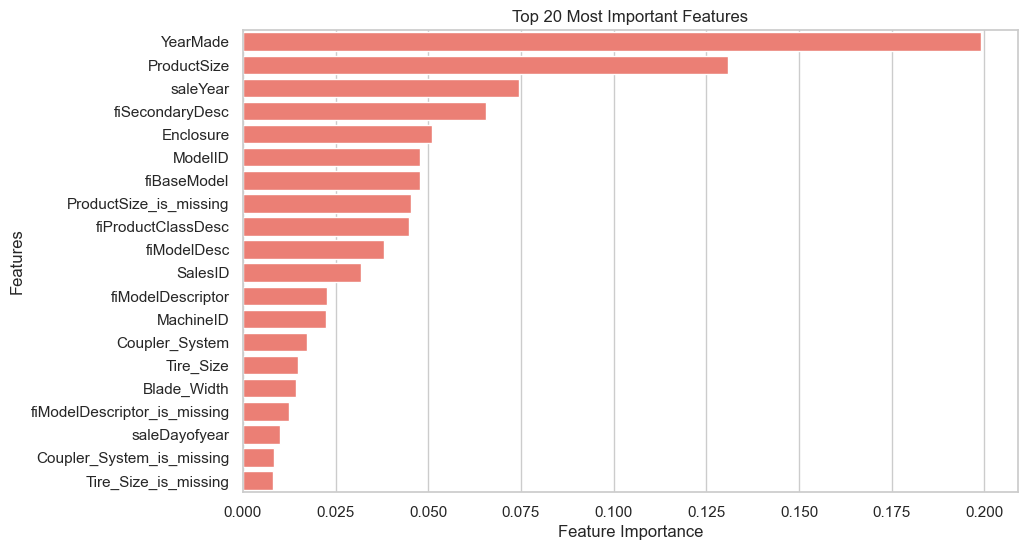

In [310]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [273]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
233186,1728883,1523610,9105,132,99.0,1986,0.0,0,4772,1852,...,True,True,True,True,True,True,True,True,True,True
142491,1508502,1153157,4138,132,99.0,1972,0.0,0,2347,713,...,True,True,True,True,True,False,False,False,True,True
115536,1452578,1544443,3854,132,99.0,1974,0.0,0,1767,535,...,True,True,True,True,True,True,True,True,False,False
92301,1403418,1390168,7110,132,99.0,1986,0.0,0,744,245,...,True,True,True,True,True,True,True,True,True,True


In [276]:
df["ProductSize"].value_counts()

ProductSize
Medium            64342
Large / Medium    51297
Small             27057
Mini              25721
Large             21396
Compact            6280
Name: count, dtype: int64

**Question to finish**: Why might knowing the feature importances of a trained machine learning model be helpful?

**Final Challenge:** What other machine learning models could you try on our dataset? Hint: https://scikit-learn.org/stable/machine_learning_map.html Check out the regression section of this map, or try to look at something like CatBoost.ai or XGBoost.ai.